In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime # to time processes
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
foo =r'C:\Users\ACER\Desktop\python project\airqo/BugolobiHOULY.csv'

In [4]:
pjme = pd.read_csv(foo, index_col=[0], parse_dates=[0])

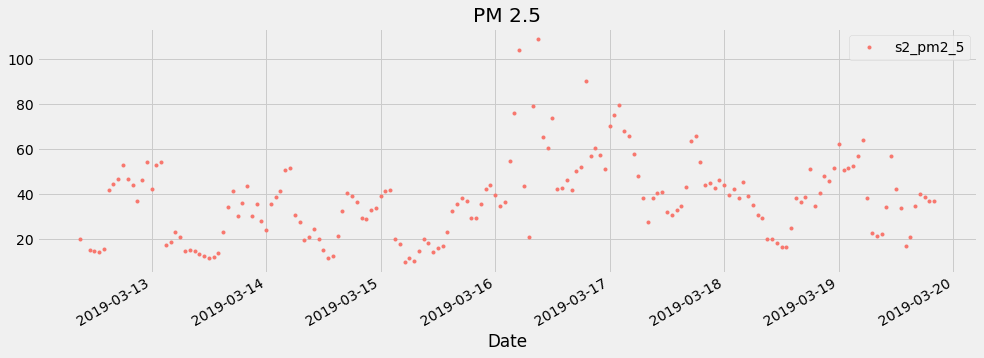

In [5]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PM 2.5')

# Train/Test Split

In [6]:
split_date = '18-03-2019'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

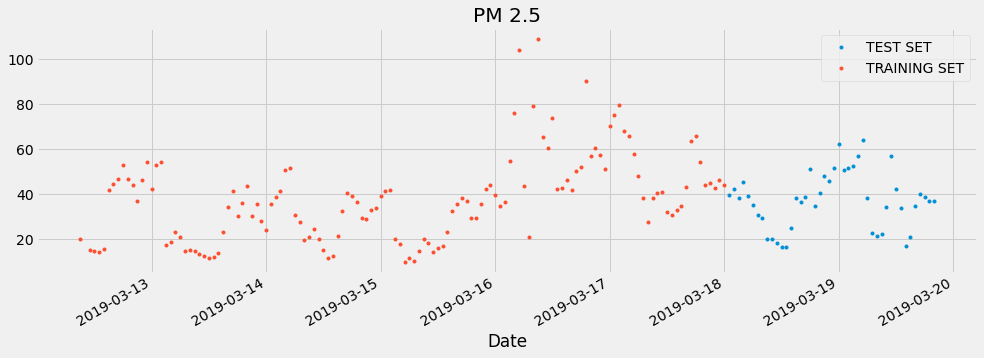

In [7]:
temp_plot = pjme_test \
    .rename(columns={'s2_pm2_5': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'s2_pm2_5': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PM 2.5', style='.')

# ARIMA Model

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [9]:
model = ARIMA(pjme_train, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.s2_pm2_5   No. Observations:                  134
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -522.426
Method:                       css-mle   S.D. of innovations             11.919
Date:                Thu, 09 Dec 2021   AIC                           1058.853
Time:                        23:00:06   BIC                           1079.138
Sample:                             1   HQIC                          1067.096
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1916      0.566      0.338      0.735      -0.918       1.302
ar.L1.D.s2_pm2_5    -0.0888      0.086     -1.034      0.301      -0.257       0.080
ar.L2.D.s2_pm2_5    -0.4407 

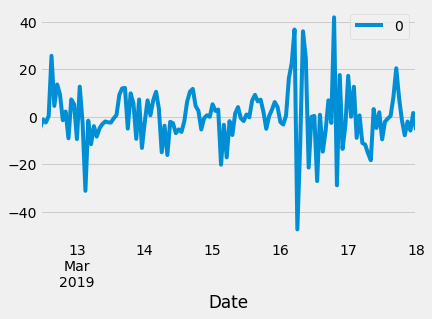

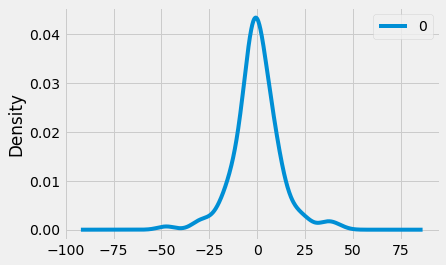

                0
count  134.000000
mean    -0.007817
std     11.967219
min    -47.428194
25%     -5.052706
50%     -0.412208
75%      6.035443
max     41.865584


In [10]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [13]:
test_length = 20
X = pjme['s2_pm2_5'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
errors = []

In [14]:
for t in range(0, test_length):
    model = ARIMA(history, order=(2,1,0)) # 2 time lags, moving-average of 0
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    errors.append((yhat-obs)[0])

predicted=43.497220, expected=27.726087
predicted=32.556292, expected=38.456739
predicted=42.083907, expected=40.636667
predicted=36.390538, expected=40.969565
predicted=40.345179, expected=32.101778
predicted=32.909481, expected=30.693043
predicted=34.534480, expected=32.933478
predicted=33.483542, expected=34.556087
predicted=33.710752, expected=43.221111
predicted=42.128102, expected=63.382222
predicted=58.898733, expected=65.765652
predicted=58.154127, expected=54.394889
predicted=54.666543, expected=43.999111
predicted=49.524533, expected=44.855870
predicted=49.233059, expected=42.526667
predicted=42.604873, expected=46.262174
predicted=47.249888, expected=44.014667
predicted=42.967066, expected=39.699348
predicted=41.094831, expected=42.258000
predicted=44.055566, expected=38.380889


Test MSE:  61.764917517388724
Test RMSE:  7.8590659443338895


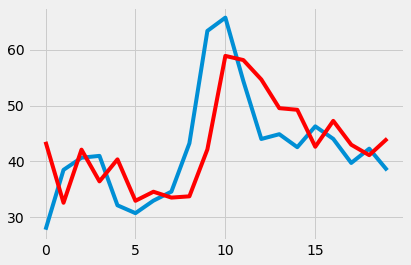

In [17]:
import math
error = mean_squared_error(test[:test_length], predictions)
print('Test MSE: ', error)
print('Test RMSE: ', math.sqrt(error))
# plot
pyplot.plot(test[:test_length])
pyplot.plot(predictions, color='red')
pyplot.show()

In [16]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(errors)

1.3004230170056692